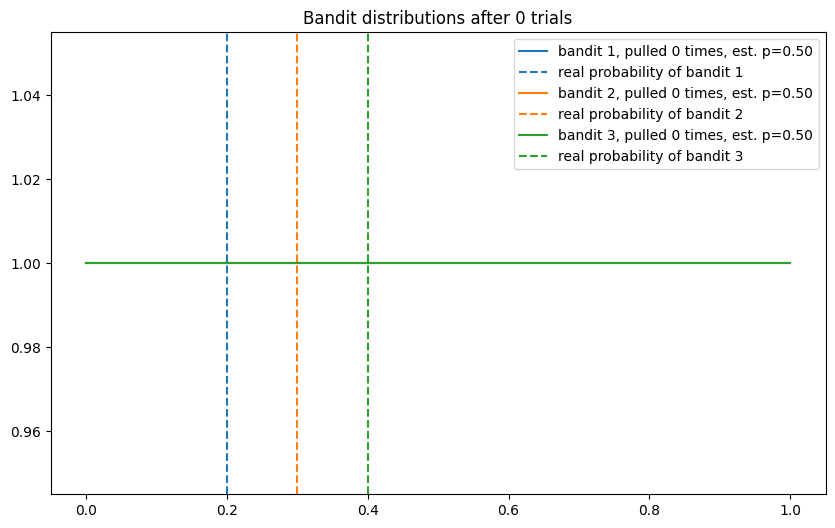

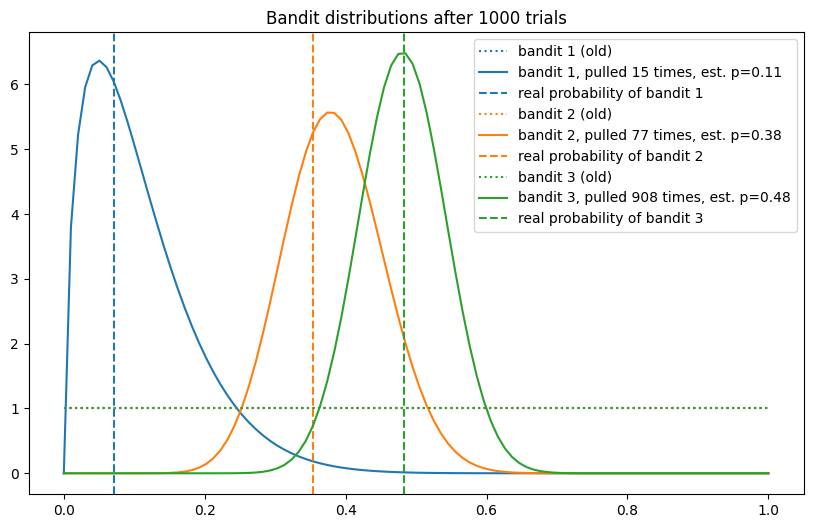

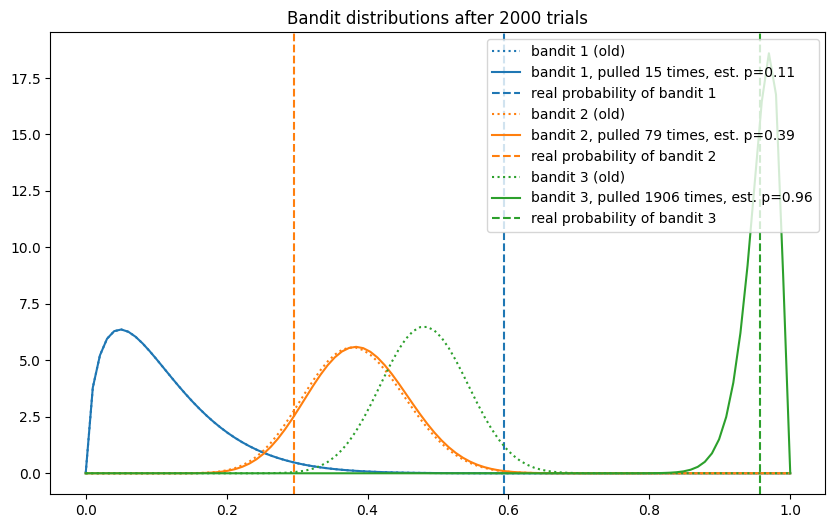

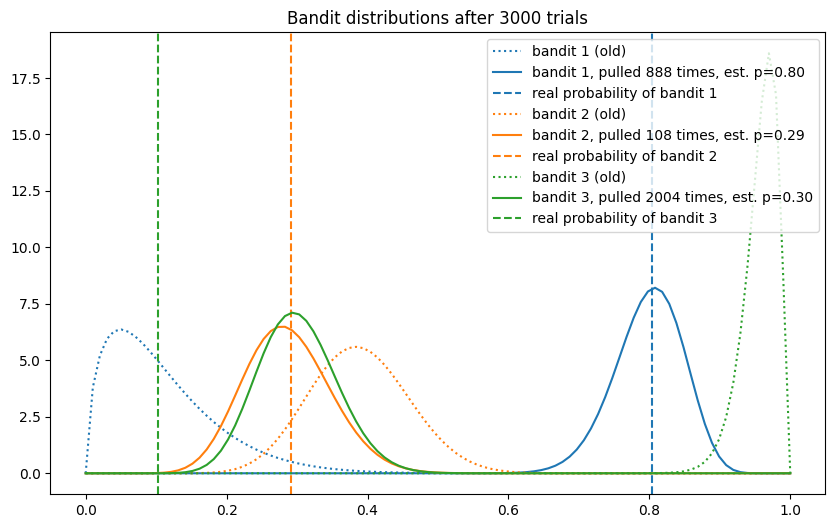

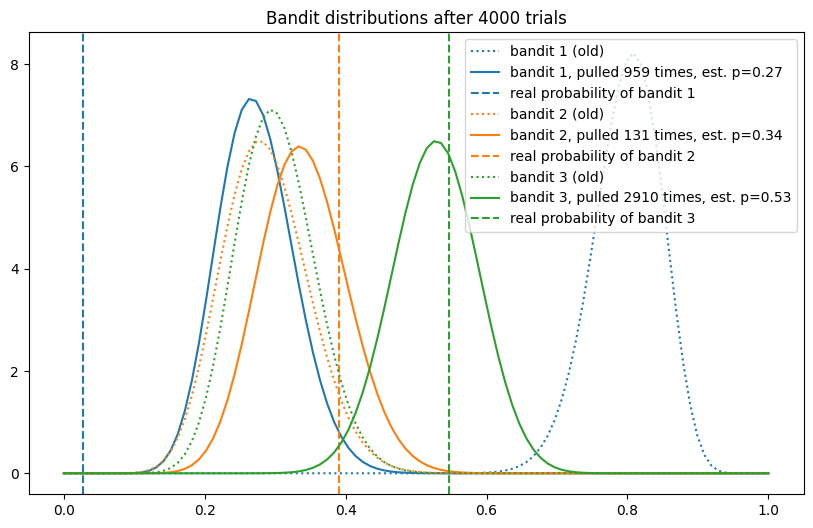

mean estimate: 0.232609279675111
mean estimate: 0.2213217787488221
mean estimate: 0.34377391314524086


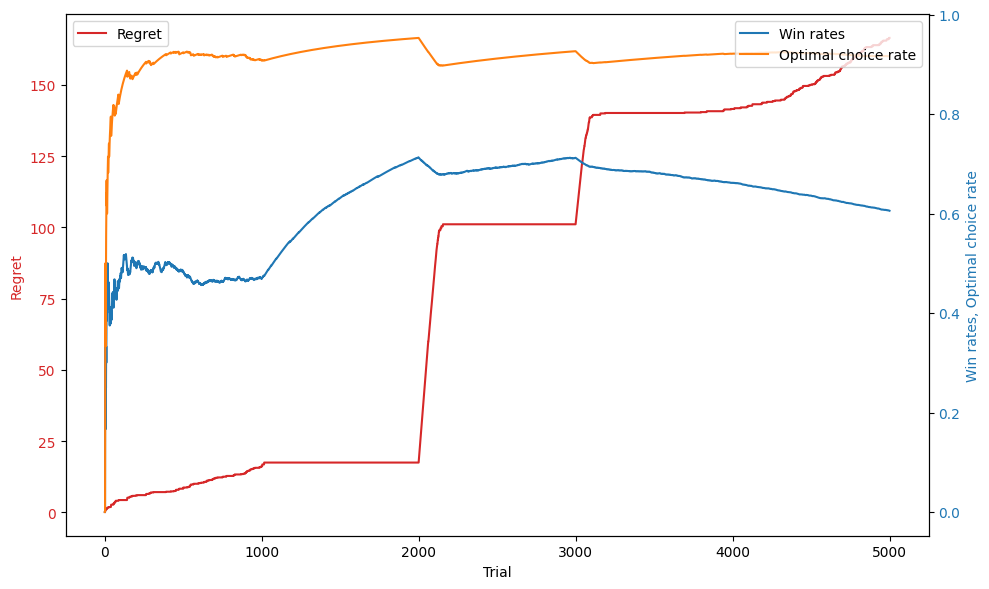

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from scipy.stats import beta


class Bandit:
    def __init__(self, p):
        # p: the reject rate
        self.p = p
        self.a = 1
        self.b = 1

    def pull(self):
        return np.random.random() < self.p

    def sample(self):
        return np.random.beta(self.a, self.b)

    def update(self, x, discount_factor):
        self.a = discount_factor*self.a + x
        self.b = discount_factor*self.b + 1 - x

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
num_trials=5000
bandit_probs=[0.2, 0.3, 0.4]
discount_factor=0.985
plot_every=1000


bandits = [Bandit(p) for p in bandit_probs]
n_bandits = len(bandits)
optimal_j = np.argmax([b.p for b in bandits])  # keep track of optimal bandit
times_optimal_chosen = np.zeros(num_trials)
rewards = np.zeros(num_trials)
cumulative_regret = np.zeros(num_trials)
beta_params = [[] for _ in range(n_bandits)]  # store parameters for beta distributions
times_pulled = [0]*n_bandits  # count times each bandit is pulled

for i in range(num_trials):
    # periodically change the bandit probabilities
    if i % plot_every == 0:
        # plot Beta distributions
        x = np.linspace(0, 1, 100)
        plt.figure(figsize=(10, 6))  
        for k, b in enumerate(bandits): 
            if i > 0:
                # plot old distribution
                old_a, old_b = beta_params[k][-1]
                y_old = beta.pdf(x, old_a, old_b)
                plt.plot(x, y_old, linestyle='dotted', color=colors[k], label=f"bandit {k+1} (old)")

            # plot current distribution
            y_new = beta.pdf(x, b.a, b.b)
            plt.plot(x, y_new, color=colors[k], label=f"bandit {k+1}, pulled {times_pulled[k]} times, est. p={b.a / (b.a + b.b):.2f}")
            plt.axvline(b.p, linestyle='--', color=colors[k], label=f"real probability of bandit {k+1}")  # indicate actual probability
            beta_params[k].append((b.a, b.b))  # save parameters
        plt.title(f"Bandit distributions after {i} trials")
        plt.legend(loc='upper right')
        plt.show()
        for b in bandits:
            b.p = np.random.random()  # new reject rate for each bandit
        optimal_j = np.argmax([b.p for b in bandits])  # new optimal bandit

    # Thompson sampling
    j = np.argmax([b.sample() for b in bandits])

    # check if the optimal bandit was chosen
    if j == optimal_j:
        times_optimal_chosen[i] = 1

    # Pull the arm for the bandit with the largest sample
    x = bandits[j].pull()
    times_pulled[j] += 1  # update times pulled

    rewards[i] = x

    # Update the distribution for all bandits
    #MIGHT BE DONE ALSO as tactic
#         for k, b in enumerate(bandits):
#             if k == j:
#                 b.update(x, discount_factor)  # update the pulled bandit based on the result
#             else:
#                 b.update(b.a / (b.a + b.b), discount_factor)  # update the non-pulled bandits based on their current estimated win rate


    # Update the distribution for the bandit whose arm we just pulled

    bandits[j].update(x, discount_factor)

    # Compute regret
    optimal_expected_reward = bandits[optimal_j].p
    chosen_expected_reward = bandits[j].p
    regret = optimal_expected_reward - chosen_expected_reward
    cumulative_regret[i] = regret if i == 0 else cumulative_regret[i-1] + regret

# Print mean estimates for each bandit
for b in bandits:
    print(f"mean estimate: {b.a / (b.a + b.b)}")

# Plot the results
cumulative_rewards = np.cumsum(rewards)
win_rates = cumulative_rewards / (np.arange(num_trials) + 1)
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Trial')
ax1.set_ylabel('Regret', color=color)
ax1.plot(cumulative_regret, color=color, label='Regret')
ax1.legend(loc='upper left')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Win rates, Optimal choice rate', color=color)  
ax2.plot(win_rates, color='tab:blue', label='Win rates')
ax2.plot(np.cumsum(times_optimal_chosen) / (np.arange(num_trials) + 1), color='tab:orange', label='Optimal choice rate')
ax2.legend(loc='upper right')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.show()
